# Basics of connectomics graph analysis

This notebook walks through the basics of representing connectomics data as graphs, inspecting them, applying classic graph analyses, and interpreting the results. We'll make use of the FlyWire dataset for examples, but familiarity with _Drosophila_ or its neurobiology isn't necessary.


## Setup


In [1]:
# If you need to install the dependencies into your environment,
# uncomment the following line and execute this cell.

# !pip3 install numpy pandas matplotlib seaborn igraph scipy pyarrow humanize

In [2]:
# Pathlib is a builtin Python library for working with file paths
# consistently across computer platforms, like Windows, MacOS, and Linux.
from pathlib import Path

# Numpy is the community standard library for working with numeric arrays.
import numpy as np

# Pandas is a popular library for working with tabular data.
import pandas as pd

# Matplotlib is the most commmon Python plotting library.
from matplotlib import pyplot as plt

# Seaborn is a popular plottling library built on top of matplotlib, making
# it sometimes simpler to produce nice plots in common cases.
import seaborn as sns

DATA_DIR = Path(".").resolve().parent / "data"


## You Wouldn't Download a Fly Brain

Let's jump straight in to the synaptic connectome of the fly by loading a list of synaptic edges and neuron annotations, then inspecting the general format of the data. In a moment we'll reflect on how else we might represent a connectome.


### Synaptic Edges


In [3]:
fw_edges = pd.read_feather(DATA_DIR / "syn_proof_analysis_filtered_630.feather")
fw_edges.head()

,pre_pt_root_id,post_pt_root_id,syn_count
0,720575940596125868,720575940605825666,2
1,720575940596125868,720575940606217138,1
2,720575940596125868,720575940608552405,5
3,720575940596125868,720575940609975854,4
4,720575940596125868,720575940611348834,7


| Python Basics                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `pandas` is a popular Python library for working with _tabular data_, data having rows representing instances sharing similar attributes in the columns. In `pandas` these tables are called DataFrames. `fw_edges` is a DataFrame we've loaded from a file. `fw_edges.head()` selects only the first few rows of that DataFrame for inspection. Row identifiers (here just 0..4) are shown on the left, columns along the top in the header. |

&nbsp;

| Computational Science Basics                                                                                                                                                                              |
| :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `feather` files are tabular data in the Apache Arrow format, a standardized format with advantages over `csv` and similar text-based formats in terms of size and performance scalability for large data. |


We're looking at the first few entries of the inter-neuronal synaptic edge list. Neurons in FlyWire and other datasets based on the same platform (which you might hear referred to as "PyChunkedGraph" or "CAVE") are identified by a `root_id`. Here, we have an entry for each presynaptic (`pre_pt_root_id`) and postsynaptic (`post_pt_root_id`) pair of neurons connected by chemical synapses. `syn_count` tells us how many postsynaptic sites detected in the dataset link those two neurons.


How many synaptic partners are there?


In [4]:
len(fw_edges)

14687178

If you have dyslexia or nystagmus or are like me that may just look like "a lot". We'll use a small utility for displaying some similar large numbers from time-to-time.


In [5]:
import humanize

humanize.intword(len(fw_edges))

'14.7 million'

And how many total synapses?


In [6]:
humanize.intword(fw_edges.syn_count.sum())

'52.8 million'

| Python Basics                                                                                                                                                                                                                                                                                                                                     |
| :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Because `syn_count` is a column in the `fw_edges` DataFrame, we can access it to perform operations just on the values in that column with `fw_edges.syn_count`. You could also access the column with `fw_edges["syn_count"]` or `fw_edges.loc[:, "syn_count"]`. When you access a single column of a DataFrame like this, it's called a Series. |


How are synaptic counts distributed across these edges?


/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

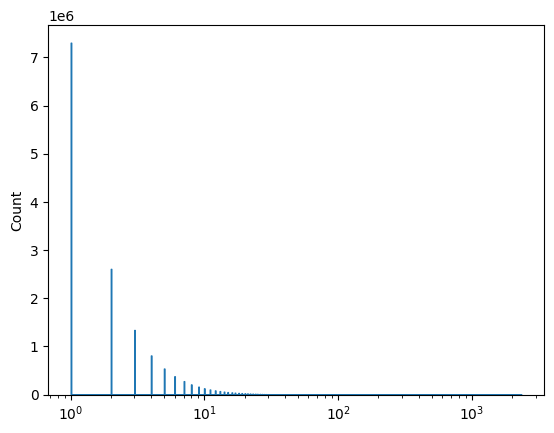

In [7]:
sns.histplot(data=fw_edges.syn_count.values, element="step", log_scale=True)

What is the distribution of output synapses?


/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='syn_count', ylabel='Count'>

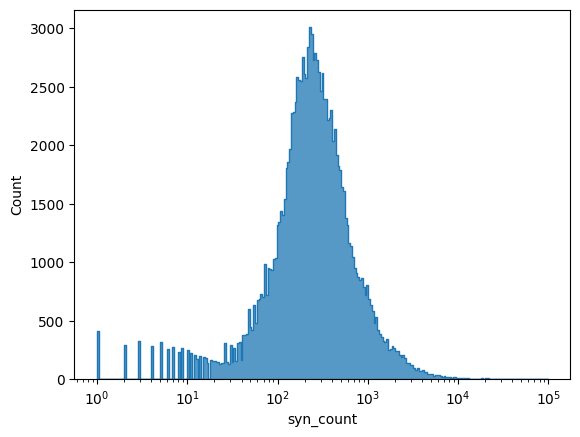

In [8]:
outputs_per_neuron = fw_edges.groupby("pre_pt_root_id").syn_count.agg("sum")
sns.histplot(
    data=outputs_per_neuron,
    element="step",
    log_scale=True,
)

What is the distribution of input synapses?


/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='syn_count', ylabel='Count'>

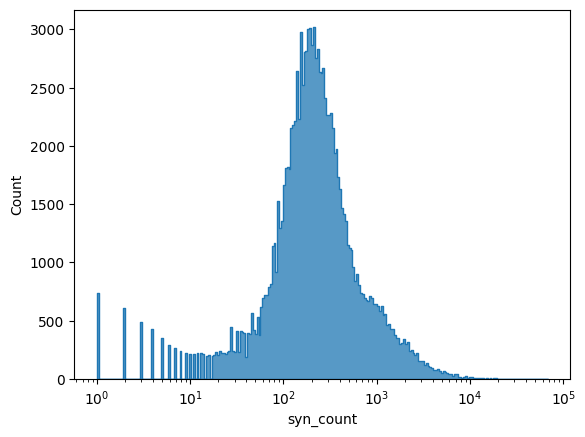

In [9]:
inputs_per_neuron = fw_edges.groupby("post_pt_root_id").syn_count.agg("sum")
sns.histplot(
    data=inputs_per_neuron,
    element="step",
    log_scale=True,
)

This looks similar to the output distribution. But that doesn't necessarily imply they're correlated. Can we look at these jointly?


In [10]:
per_neuron_counts = pd.merge(
    inputs_per_neuron,
    outputs_per_neuron,
    left_index=True,
    right_index=True,
    suffixes=["_inputs", "_outputs"],
)
per_neuron_counts.head()


,syn_count_inputs,syn_count_outputs
720575940596125868,151,181
720575940597856265,425,798
720575940597944841,271,343
720575940598267657,834,576
720575940599333574,381,776


Because we're only merging where we have both inputs and outputs for a neuron (`pd.merge(how="inner")`), we are not including cases with no output or input (_sinks_ and _sources_, respectively, in graph nomenclature). This is fine for what we want to plot.


/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


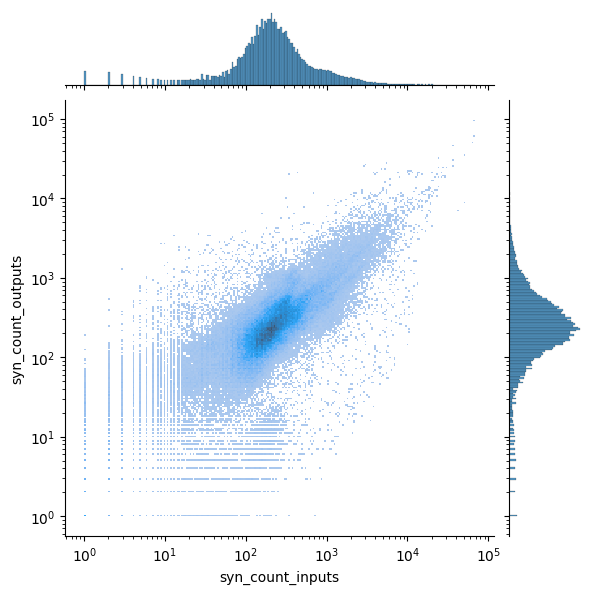

In [11]:
sns.jointplot(
    data=per_neuron_counts,
    x="syn_count_inputs",
    y="syn_count_outputs",
    kind="hist",
    log_scale=True,
)


### Neuron Annotations


In [12]:
fw_annot = pd.read_csv(
    DATA_DIR / "Supplemental_file1_annotations.tsv", sep="\t"
).set_index("root_id")
# We have to do some magical cleanup to make later things easy. Don't worry about this.
fw_annot = fw_annot[~fw_annot.index.duplicated()]
fw_annot.head()

/var/folders/rf/8cfvv8zn689czv361jw9prvd1s1jvg/T/ipykernel_88454/3337038651.py:1: DtypeWarning: Columns (14,15,16,17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  fw_annot = pd.read_csv(


,supervoxel_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,super_class,...,hemibrain_type,ito_lee_hemilineage,hartenstein_hemilineage,morphology_group,top_nt,top_nt_conf,side,nerve,fbbt_id,status
root_id,,,,,,,,,,,,,,,,,,,,,
720575940628857210,78112261444987077,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,central,...,PS180,SMPpv2_ventral,CP1_ventral,SMPpv2_ventral_3,acetylcholine,0.914499,left,NaN,FBbt_20001935,NaN
720575940626838909,82475466912542440,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,central,...,NaN,VLPl2_medial,BLAv2_medial,VLPl2_medial_1,acetylcholine,0.638088,right,NaN,NaN,NaN
720575940626046919,83038623024880664,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,central,...,AVLP429,NaN,NaN,NaN,acetylcholine,0.838454,right,NaN,FBbt_20000538,NaN
720575940630311383,79801523353604463,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,central,...,AVLP151,putative_primary,putative_primary,NaN,acetylcholine,0.755116,right,NaN,FBbt_20000260,NaN
720575940633370649,83038554439606237,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,visual_projection,...,LC27,NaN,NaN,NaN,acetylcholine,0.886547,right,NaN,FBbt_00051248,NaN


We again identify neurons by `root_id` and see that we have many attributes for each - too many to display by default. Let's get a list.


In [13]:
fw_annot.columns

Index(['supervoxel_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x', 'soma_y',
       'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'side', 'nerve', 'fbbt_id', 'status'],
      dtype='object')

`hemibrain_type` seems like a useful description. These are the neuronal type names from the earlier "hemibrain" partial connectome, mapped onto the FlyWire brain. Let's look at that annotation applied to one of our synaptic edges:


In [14]:
# Choose an arbitrary edge.
# I've intentionally pre-selected one to be between neurons with some annotations.
edge_of_interest = fw_edges.iloc[116667]
root_ids_in_edge_of_interest = edge_of_interest.loc[
    ["pre_pt_root_id", "post_pt_root_id"]
]
neuron_annotations_for_edge = fw_annot.loc[root_ids_in_edge_of_interest]
neuron_annotations_for_edge.hemibrain_type

root_id
720575940604787424        LT1
720575940605752422    PVLP106
Name: hemibrain_type, dtype: object

| Python Basics                                                                                                                                                                                                                                                                                                                                                     |
| :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `pandas` provides many different ways to index into a DataFrame. `.iloc` selects rows (or columns) based on their sequential order in the table, similar to how you index a `list` or `ndarray` with `[]`. `.loc` indexes based on the values of each row's `index` column(s), sort of the name or identifier for that row. In our case, the index is `root_id`s. |


We can make it easier and more elegant to inspect these annotations later, but for now we've at least seen that we can stitch things together.


Before we move on, let's construct an annotation we can use as a basic label for future inspection.

`hemibrain_type` seemed ok at first glance, but the hemibrain isn't a full brain. Is it missing for lots of neurons?


In [15]:
fw_annot.hemibrain_type.isna().sum()

101824

| Python Basics                                                                                                                                                                                                                              |
| :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Many data types and libraries have various types indicating invalid, missing, or unrepresentable values, such as `NaN`, `NA`, or `None`. `pandas` has various methods for working with common cases of these, such as `isna` and `fillna`. |


Besides not existing for many neurons, `hemibrain_type` also reflects a typing process that wasn't comprehensive for the full brain or consistent with some literature. Schlegel, et al. have their own extension and correcion to this type in the `cell_type` column. However, it's only present when it differs from `hemibrain_type` (which it strove to match when reasonable):


In [16]:
fw_annot.cell_type.isna().sum()

104982

Let's combine these and see how much better we do:


In [17]:
fw_annot["merged_type"] = fw_annot.cell_type.fillna(fw_annot.hemibrain_type)
fw_annot.merged_type.isna().sum()

83100

This is good enough for now, but of course what circuits, systems, and question you're interested in will determine what annotations are relevant.


We've seen already there are about 53 million synapses linking 14 million unique pairs of neuronal partners. How many neurons total are those drawn from?


In [18]:
n_neurons = len(fw_annot)
humanize.intcomma(n_neurons)

'128,775'

As an aside: evenly distributed between hemispheres?


In [19]:
fw_annot.side.value_counts()

side
right     65411
left      63009
center      330
na           23
Name: count, dtype: int64

| Python Basics                                                                                                       |
| :------------------------------------------------------------------------------------------------------------------ |
| Because `fw_annot.side` is a Series, pandas provides many useful basic statistics, like `value_counts`, as methods. |


A little lopsided.

Back to the point, 14 million edges seems large, but how many potential pairs (including autapses) actually have a synaptic edge?


In [20]:
len(fw_edges) / (n_neurons * n_neurons)

0.000885676744042214

Less than 0.1%.


Are any annotated neurons not represented in the synaptic edge list?


In [21]:
(
    (~fw_annot.index.isin(fw_edges.pre_pt_root_id))
    & (~fw_annot.index.isin(fw_edges.post_pt_root_id))
).sum()

1453

This goes beyond a normal **Python Basics** footnote.

Here we're using several boolean logic and `pandas` features to answer this question:

- Because we want to look at the `root_id`s indexing each row in `fw_annot`, we access `fw_annot.index`
- Because we want to compare all the values in that index with what values we see in the edge list, we use `isin` which returns a list of boolean values (`True` or `False`), one for each `root_id` in `fw_annot`
- Because we want to know which values are **not in** in the edge list, we negate these boolean values with `~`
- Because we need to check both the presynaptic and postsynaptic side of the edge list, we do this for each, and then combine them with a boolean operation (`&`)
- Because we only care how many neurons are missing, we can just `sum` the boolean list at the end. `True`s get converted to 1 and `False` to zero.


These neurons are synaptically _disconnected_, something we may need to be mindful of going forward.


### Building an Adjacency Matrix

We already have the synaptic connectome as an _edge list_. Edge lists represent graphs as pairs of _vertices_ (also called _nodes_, though this terminology is more common when referring to graphs as networks). In our case, because chemical synaptic edges are _directed_ -- synapses release transmitters from a presynaptic zone to a postsynaptic partner -- this list represents a _directed graph_. Connectomics is sometimes also concerned with undirected graphs, such as of neurons who neurites abut or approach each other (e.g., for evaluating [Peters' rule](http://www.scholarpedia.org/article/Computational_neuroanatomy#Potential_synaptic_connectivity_between_individual_cells) or considering other molecular mechanisms). Our synaptic edges also have a value associated with them, `syn_count`. Because this is a scalar value, we can consider it a _weight_ on that edge.

Often it is useful instead to represent or at least conceptualize our graph as an _adjacency matrix_, a matrix having a row and column for each vertex, which the entry at position `A[i,j]` representing the edge weight from vertex `i` to vertex `j`. For example, we might have a synaptic edge list for 3 neurons `A`, `B`, `C`:

| pre | post | syn_count |
| :-- | ---- | --------- |
| A   | B    | 5         |
| A   | C    | 3         |
| B   | C    | 2         |
| C   | A    | 1         |

The graph can equivalently be represented as an adjacency matrix:

|     | A   | B   | C   |
| --- | --- | --- | --- |
| A   | 0   | 5   | 3   |
| B   | 0   | 0   | 2   |
| C   | 1   | 0   | 0   |


So what's stopping us? We have an edge list, we'd like an adjacency matrix, let's get started! First let's just create a zeroed out array and...

```python
easy_peasy = np.zeros((n_neurons, n_neurons))
```

Strange. Why isn't that in a code cell? Let's just check one tiny detail:


In [22]:
humanize.naturalsize(n_neurons * n_neurons * 4)
# 4 is the minimum number of bytes per edge you're likely to use during analysis.

'66.3 GB'

You likely don't have that much memory in your laptop or whatever free Jupyterlab cloud you're running this in. There are still contexts where you may need a dense adjacency matrix, and at least for the fly you can generate it on an adequate workstation or server, but for now let's try to do better.

As we saw earlier, the fly brain connectome is sparse, with less than 0.1% of potential edges existing. Edge lists are an efficient structure for naively representing sparse graphs. Efficient, non-naive structures also exist for representing sparse arrays and thus sparse adjacency matrices. Choosing and using the appropriate structure is non-trivial. For this graph, because we haven't sorted the neurons into any meaningful order we would expect to make parts of the matrix dense, we will use a simple format that's effectively an a compressed edge list.


In [23]:
import scipy.sparse

fw_edges_only_anno = fw_edges.loc[
    fw_edges.pre_pt_root_id.isin(fw_annot.index)
    & fw_edges.post_pt_root_id.isin(fw_annot.index)
]
pre_loc = fw_annot.index.get_indexer(fw_edges_only_anno.iloc[:, 0].to_numpy())
post_loc = fw_annot.index.get_indexer(fw_edges_only_anno.iloc[:, 1].to_numpy())
fw_adj_sp = scipy.sparse.coo_array(
    (fw_edges_only_anno.iloc[:, 2].to_numpy(), np.stack([pre_loc, post_loc], axis=0))
)

In [24]:
humanize.naturalsize(fw_adj_sp.size)

'14.7 MB'

This can fit on your laptop. This can fit on your earbuds.

Operations can be performed on these sparse matrices efficiently:


In [25]:
fw_adj_sp.count_nonzero()

14680956

In [26]:
fw_adj_sp.sum()

52774291

However, care must be taken to avoid materializing the dense matrix. Generally we will be avoiding creating adjacency matrices for the whole graph in this tutorial, but it's important to be aware of this issue and know of avenues to get it when you need to.

Note a slight descrepency in these values from the values of `len(fw_edges)` and `fw_edges.syn_count.sum()`, respectively, because some edges reference `root_id`s not in `fw_annot`, which we used to impose a dense index on `root_id` for the adjacency matrix. For example, here's a check to find out how many presynaptic roots in the edge list are not in the annotations:


In [27]:
fw_edges.loc[
    ~fw_edges.pre_pt_root_id.isin(fw_annot.index), "pre_pt_root_id"
].drop_duplicates().count()

67

### Building a Graph

With any representation of the brain graph, we can build a graph model. Really, our representations are already a graph, but these models provide convenient, uniform ways to do things like traversing the graph, measuring its properties, or applying algorithms to it.


In [28]:
import igraph

fw_graph = igraph.Graph.DataFrame(fw_edges, directed=True, use_vids=False)

`igraph` is a library for graph analysis that's also available in different programming environments, including C and R. It's not the most intuitive to use or well-documented -- for that the `networkx` library is most common in Python -- but it sometimes performs better for large graphs and has several sophisticated algorithms already implemented we will make use of in future tutorials.


In [29]:
fw_graph.summary()

'IGRAPH DN-- 127400 14687178 -- \n+ attr: name (v), syn_count (e)'

This is telling us a few things about our graph:

- It is directed (`D`)
- It has an attribute called `name` for vertices that some functions may make special use of by default (`N`)
- It has 127400 vertices
- It has 14687178 edges
- Vertices have one attribute: `name`
- Edges have one attribute: `syn_count`


We can select vertices and traverse from in our graph. For example, using one of the arbitrary neurons we looked at earlier, we can find its downstream partners (in directed graphs, these are "outbound edges" or "successors" for vertices at the other end of those):


In [30]:
voi = fw_graph.vs.find(name_eq=720575940604787424)
voi_downstream = fw_graph.neighbors(voi, mode="out")
len(voi_downstream)

739

We can as easily look at upstream partners:


In [31]:
voi_upstream = fw_graph.neighbors(voi, mode="in")
len(voi_upstream)

1900

Generally, these are called neighborhoods. Neighbors reached after traversing one edge are in the 1-neighborhood or "first order neighborhood" and so are 1-neighbors. But we can as easily ask about the neighborhood reached after traversing another synapse from those downstream partners:


In [32]:
len(fw_graph.neighborhood(vertices=voi, order=2))

49353

In 2 synapses, we've reached nearly half the fly brain. In general it is the case for fly nervous systems that the shortest path between any two neurons is quite small. We'll examine ths more later.

Returning to our vertex of interest and its downstream partners, how are synapses distributed among them, that is, how many presynaptic-to-postsynaptic sites does it share with each partner?


/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

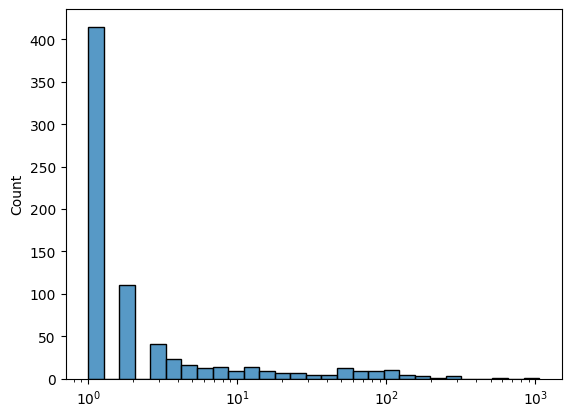

In [33]:
voi_outgoing = fw_graph.es.select(_source=voi)
sns.histplot(data=voi_outgoing["syn_count"], log_scale=True)

Earlier we saw there were some disconnected neurons. This means we expect the graph to be broken into several pieces that can't be reached from each other, _connected components_:


In [34]:
len(fw_graph.connected_components())

1047

Is this just one giant brain component (_giant component_ is actual graph nomenclature) and a bunch of isolated, disconnected neurons we saw before, or are there small components in between?


/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'number of components')

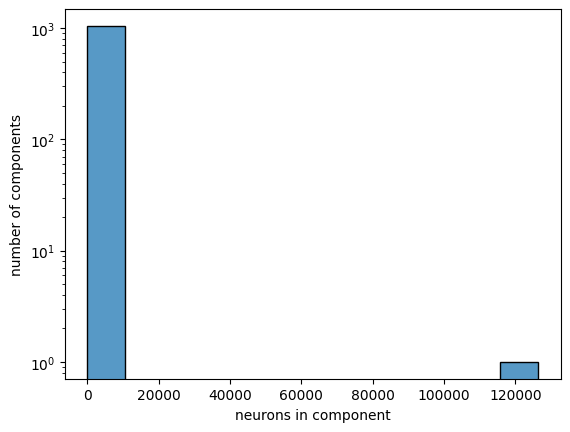

In [35]:
cc_sizes = [len(cc) for cc in fw_graph.connected_components()]
ax = sns.histplot(cc_sizes)
ax.set_yscale("log")
ax.set_xlabel("neurons in component")
ax.set_ylabel("number of components")

As we expected, just the giant brain component and some isolated vertices we don't need to worry about.


### Example: finding shortest paths to DNs

Let's start from our neuron/vertex of interest `voi` and find the shortest path from it to _each_ descending neuron (DN -- neurons that have a soma in the brain but extend their neurites down into the ventral nerve cord).

First, how many DNs are there, and how do we find them? The annotations consider DNs as their own `cell_class`:


In [36]:
fw_annot.cell_class.value_counts()

cell_class
optic_lobes             67390
Kenyon_Cell              5177
L1-5                     4588
visual                   4213
CX                       2859
mechanosensory           2646
AN                       2364
olfactory                2276
medulla_intrinsic        1515
DN                       1301
glia                      743
ALPN                      685
LHLN                      479
ALLN                      424
gustatory                 335
DAN                       326
bilateral                 216
TuBu                      150
unknown_sensory           133
motor                     100
MBON                       97
mAL                        77
hygrosensory               74
ocellar                    62
trachea                    54
LHCENT                     42
pars intercerebralis       40
thermosensory              29
pars lateralis             28
ALIN                       24
ALON                       16
MBIN                        4
CSD                         2

Fortunately the `cell_class` annotation for DNs is simply `DN`. There are about 1300 of them.

Now we need to select them all from the annotation DataFrame, then use their `root_id` to find them in the graph:


In [37]:
dns = fw_annot.loc[fw_annot.cell_class == "DN"]
dns_vs = fw_graph.vs.select(name_in=dns.index)

`dns_vs` is a sequence of igraph vertices. This is important, because as discussed earlier, vertices in the graph are _named_ with their `root_id`, but _indexed_ by numbers internal to the graph. This sequence of igraph vertices has those indices.


Now we find the shortest path from our neuron to **each** DN.


In [38]:
dn_paths = fw_graph.get_shortest_paths(voi, to=dns_vs, output="epath")

`output="epath"` tells igraph that we want the found paths returned as a list of edges, rather than a list of vertices (`"vpath"`), because that makes it easier for us to look at just that path in whole graph later.


How close is our neuron to all DNs?


/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

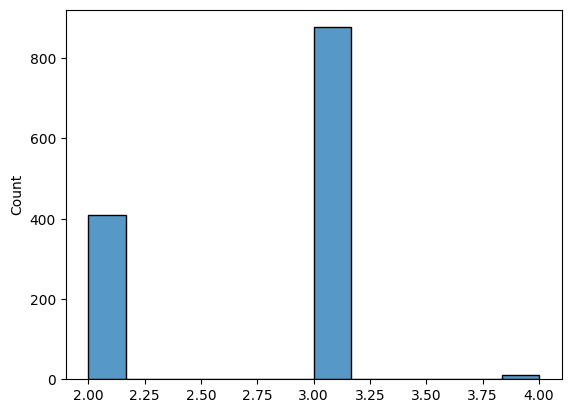

In [39]:
dn_path_lengths = [len(path) for path in dn_paths]
sns.histplot(dn_path_lengths)

Again we see that overall, path lengths in the fly connectome are short. Most DNs are 3 synapses away or less.


Let's visualize a specific path. The whole connectome is too big to visualize meaningfully in the classic graph format, but we can pull out the path that we've found. Selecting a particular part of the graph like this, but still containing its vertices and edges, is called a _subgraph_.

In this case, we want to select the subgraph _induced_ by the edges in our path. We could instead take the vertices in the path, and select the subgraph induced by those vertices. In general, selecting but the vertices in a path could contain edges not in the path, although in this specific case that's not possible because the path is a shortest path (any other edge would imply the existence of a shorter path).


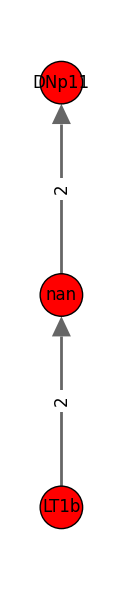

In [40]:
# Choose an arbitrary path to a DN from those we found.
our_path = dn_paths[0]

# Get the subgraph spanned by the edges in our path
our_path_graph = fw_graph.subgraph_edges(our_path)

# Plot it!
fig, ax = plt.subplots(figsize=(6, 6))
igraph.plot(
    our_path_graph,
    target=ax,
    layout="tree",
    vertex_label=fw_annot.loc[our_path_graph.vs["name"]].merged_type,
    edge_width=our_path_graph.es["syn_count"],
    edge_label=our_path_graph.es["syn_count"],
    edge_color="#666",
    edge_align_label=True,
    edge_background="white",
)

# Have matplotlib try to expand the plot area to fit our long vertex names
fig.tight_layout()
plt.show()


## Exercises & Thoughts


What is the degree distribution for all vertices in the graph?


How could we model and test the distribution of synapses (across the graph or with partner)? Exponential? Power law?


What alternative ways to measure path length better account for synaptic strength?
